In [1]:
import sys

sys.path.append("../")

DATA_PATH = '/mnt/d/Working/PersonalProjects/Trading/trading-agent/crypto-pair-trading/data/crypto/'

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import backtrader as bt

import empyrical
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6) # (w, h)
plt.ioff()

In [3]:
symbol = 'ETH-USDT'
start_date = '2022-01-01'
end_date = '2022-12-11'
timeframe = '1d'

file = f'{DATA_PATH}/{timeframe}/{symbol}.csv'
# print(file)
df = pd.read_csv(file, 
                parse_dates=['open_time'], 
                index_col=['open_time'])
df = df[(df.index > start_date) & (df.index < end_date)]
df = df[~df.index.duplicated(keep='first')]
# df.rename(columns={'open': 'Open',
#         'high': 'High',
#         'low': 'Low',
#         'close': 'Close',
#         'volume': 'Volume'}, inplace=True)
df.tail()

,open,high,low,close,volume
open_time,,,,,
2022-12-06,1258.67,1274.42,1240.55,1270.72,4094634.401
2022-12-07,1270.72,1278.30,1217.02,1230.83,4598453.506
2022-12-08,1230.78,1294.31,1221.00,1279.73,5403214.246
2022-12-09,1279.72,1297.63,1254.00,1262.31,4410565.839
2022-12-10,1262.31,1283.92,1258.58,1265.88,2219440.107


In [5]:
class DynamicBBStrategy(bt.Strategy):
    std_look_back = 30
    look_back_days = 20
    look_back_ceiling = 60
    look_back_floor = 20
    buy_point = 0.0
    sell_point = 0.0
    long_liq_point = 0.0
    short_liq_point = 0.0
    up_band = 0.0
    down_band = 0.0
    yesterday_price = 0.0

    def __init__(self) -> None:
        super().__init__()
        
        self.bar_count = 0
        self.calculated_at = None
    
    @property
    def today(self):
        return self.data.datetime[0]

    def log(self, txt, dt=None):
        dt = dt or self.data.datetime[0]
        dt = bt.num2date(dt)
        print('%s, %s' % (dt.isoformat(), txt))

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return  # Await further notifications

        if order.status == order.Completed:
            if order.isbuy():
                buytxt = f'BUY COMPLETE {order.data._name}, ' \
                         f'price: {order.executed.price:.4f}, ' \
                         f'size: {order.executed.size}, ' \
                         f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(buytxt, order.executed.dt)
            else:
                selltxt = f'SELL COMPLETE {order.data._name}, ' \
                          f'price: {order.executed.price:.4f}, ' \
                          f'size: {order.executed.size}' \
                          f'cost {order.executed.price * order.executed.size:.4f}'
                self.log(selltxt, order.executed.dt)

        elif order.status in [order.Expired, order.Canceled, order.Margin]:
            self.log('Order cancelled %s ,' % order.Status[order.status])
            pass  # Simply log

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log('OPERATION PROFIT, GROSS %.4f, NET %.4f' %
                 (trade.pnl, trade.pnlcomm))
        self.log(f'ACCOUNT VALUE: {self.broker.get_value()}')

    def get_price_series(self, series_name, lookback):
        d = getattr(self.data0, series_name)

        data = d.get(size=lookback)
        t = [bt.num2date(dt) for dt in self.data0.datetime.get(size=lookback)]
        s = pd.Series(data, index=t)
        return s

    def calculate_bb(self):
        close_series = self.get_price_series('close', self.std_look_back + 2)
        today_volatility = np.std(close_series[1 : self.std_look_back + 1])
        yesterday_volatility = np.std(close_series[0 : self.std_look_back])

        delta_volatility = (
            today_volatility - yesterday_volatility
        ) / today_volatility
        self.look_back_days = int(
            round((1 + delta_volatility) * self.look_back_days)
        )
        self.look_back_days = min(self.look_back_days, self.look_back_ceiling)
        self.look_back_days = max(self.look_back_days, self.look_back_floor)

        bb_close_series = self.get_price_series('close', self.look_back_days)
        self.up_band = bb_close_series.mean() + (bb_close_series.std() * 2.0)
        self.down_band = bb_close_series.mean() - (bb_close_series.std() * 2.0)

        high_series = self.get_price_series('high', self.look_back_days)
        low_series = self.get_price_series('low', self.look_back_days)
        self.buy_point = high_series.max()
        self.sell_point = low_series.min()
        self.long_liq_point = self.short_liq_point = bb_close_series.mean()
        self.calculated_at = self.today

    def check_trading_signals(self):
        if not self.position:
            if self.data0.close[1] > self.up_band and self.data0.high[0] >= self.buy_point:
                size = (self.broker.get_value() * 0.15) / self.data0.close[0]
                self.log(f'Long at {self.data0.close[0]}, liq = {self.long_liq_point}')
                self.buy(size=size)
            elif self.data0.close[1] < self.down_band and self.data0.low[0] >= self.sell_point:
                size = (self.broker.get_value() * 0.15) / self.data0.close[0]
                self.sell(size=size)
                self.log(f'Short at {self.data0.close[0]}, liq = {self.short_liq_point}')
        else:
            action = (self.data0.close[0] + self.data0.high[0] + self.data0.low[0]) / 3
            if (
                self.data0.close[0] <= self.long_liq_point and self.position.size > 0
                or self.data0.close[0] >= self.short_liq_point and self.position.size < 0
            ):
                self.close()

    def next(self):
        if self.bar_count < 60:
            self.bar_count += 1
            return
        
        if self.calculated_at is None:
            self.calculate_bb()
            return
        else:
            self.check_trading_signals()
            self.calculate_bb()
        
        self.bar_count += 1


# Create a cerebro
cerebro = bt.Cerebro()

# Create the 1st data
data0 = bt.feeds.PandasData(
    dataname=df,
    plot=False,
)

# Add the 1st data to cerebro
cerebro.adddata(data0, name=symbol)

# Add the strategy
cerebro.addstrategy(DynamicBBStrategy)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name="return")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, riskfreerate=0.0)
cerebro.addanalyzer(bt.analyzers.Returns)
cerebro.addanalyzer(bt.analyzers.DrawDown)

# Add the commission - only stocks like a for each operation
cerebro.broker.setcash(1000)
cerebro.broker.setcommission(commission=0.04/100, leverage=5)

print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# And run it
results = cerebro.run()
first_strat = results[0]
# print_analysis(first_strat.analyzers.ta.get_analysis())
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
# Print out the final result
print(
    f"Norm. Annual Return: {results[0].analyzers.returns.get_analysis()['rnorm100']:.2f}%"
)
print(
    f"Max Drawdown: {results[0].analyzers.drawdown.get_analysis()['max']['drawdown']:.2f}%"
)

Starting Portfolio Value: 1000.00
2022-03-22T00:00:00, Long at 2968.49, liq = 2703.7875
2022-03-23T00:00:00, BUY COMPLETE ETH-USDT, price: 2968.4800, size: 0.05053074121859936, cost 149.9995
2022-04-12T00:00:00, SELL COMPLETE ETH-USDT, price: 2978.6900, size: -0.05053074121859936cost -150.5154
2022-04-12T00:00:00, OPERATION PROFIT, GROSS 0.5159, NET 0.3957
2022-04-12T00:00:00, ACCOUNT VALUE: 1000.3957129045407
2022-04-29T00:00:00, Short at 2815.37, liq = 3073.8308
2022-04-30T00:00:00, SELL COMPLETE ETH-USDT, price: 2815.3800, size: -0.05330004828341608cost -150.0599
2022-07-11T00:00:00, BUY COMPLETE ETH-USDT, price: 1167.8100, size: 0.05330004828341608, cost 62.2443
2022-07-11T00:00:00, OPERATION PROFIT, GROSS 87.8156, NET 87.7306
2022-07-11T00:00:00, ACCOUNT VALUE: 1088.1263517671196
2022-07-15T00:00:00, Long at 1230.58, liq = 1144.411
2022-07-16T00:00:00, BUY COMPLETE ETH-USDT, price: 1230.5900, size: 0.13263579187461844, cost 163.2203
2022-08-20T00:00:00, SELL COMPLETE ETH-USDT, pri

IndexError: array index out of range

In [7]:
results

NameError: name 'results' is not defined

In [6]:
# If no name has been specified, the name is the class name lowercased
return_analyzer = results[0].analyzers.getbyname('return')
# print(tret_analyzer.get_analysis())
account_return = pd.Series(return_analyzer.get_analysis(), name='return')
cum_r = (1 + account_return).cumprod()

cum_r.plot()
plt.show()


NameError: name 'results' is not defined

# Load mean reversion return

In [ ]:
m_ret = pd.read_csv('saved/ETHXMR.csv', parse_dates=['date'], index_col=['date'])
m_ret.head()

,return
date,
2022-06-14,0.0
2022-06-15,0.0
2022-06-16,0.0
2022-06-17,0.0
2022-06-18,0.0


In [ ]:
m_ret['hedge_ret'] = account_return
m_ret.dropna(inplace=True)

m_ret['p_ret'] = m_ret['return'] + m_ret['hedge_ret']
m_ret['p_ret'] = (1 + m_ret['p_ret']).cumprod()
m_ret['return'] = (1 + m_ret['return']).cumprod()
m_ret['hedge_ret'] = (1 + m_ret['hedge_ret']).cumprod()
m_ret

,return,hedge_ret,p_ret
date,,,
2022-10-02,1.000000,1.000000,1.000000
2022-10-03,1.000000,1.000000,1.000000
2022-10-04,1.000000,1.000000,1.000000
2022-10-05,1.000000,1.000000,1.000000
2022-10-06,1.000000,1.000000,1.000000
...,...,...,...
2022-12-06,1.034786,0.997744,1.032451
2022-12-07,1.034786,0.998187,1.032910
2022-12-08,1.035613,1.002013,1.037694


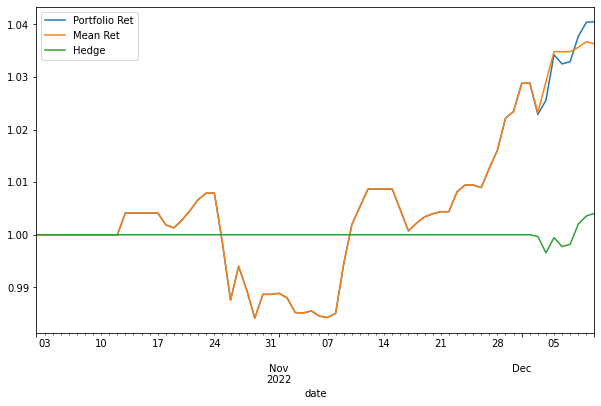

In [ ]:
m_ret['p_ret'].plot()
m_ret['return'].plot()
m_ret['hedge_ret'].plot()
plt.legend(['Portfolio Ret', 'Mean Ret', 'Hedge'])
plt.show()